Trial 46 Complete [00h 19m 34s]
val_accuracy: 0.9801852107048035

Best val_accuracy So Far: 0.9816666841506958
Total elapsed time: 05h 58m 39s

The hyperparameter search is complete. The optimal number of LSTM units is 256,
the optimal number of units in the first layer is 128, in the second layer is 192,
the optimal dropout rates are 0.3, 0.3,
and the optimal learning rate is 0.001.

Epoch 1/50


2024-08-25 09:52:06.603305: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_3_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


675/675 ━━━━━━━━━━━━━━━━━━━━ 151s 167ms/step - accuracy: 0.7266 - loss: 0.9216 - val_accuracy: 0.9339 - val_loss: 0.2280 - learning_rate: 9.5570e-04
Epoch 2/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 110s 161ms/step - accuracy: 0.8938 - loss: 0.3805 - val_accuracy: 0.9589 - val_loss: 0.1625 - learning_rate: 8.3066e-04
Epoch 3/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 110s 162ms/step - accuracy: 0.9222 - loss: 0.2808 - val_accuracy: 0.9248 - val_loss: 0.2667 - learning_rate: 6.4702e-04
Epoch 4/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 111s 162ms/step - accuracy: 0.9397 - loss: 0.2274 - val_accuracy: 0.9769 - val_loss: 0.1061 - learning_rate: 4.3733e-04
Epoch 5/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 111s 163ms/step - accuracy: 0.9520 - loss: 0.1822 - val_accuracy: 0.9789 - val_loss: 0.0948 - learning_rate: 2.3875e-04
Epoch 6/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 111s 163ms/step - accuracy: 0.9610 - loss: 0.1551 - val_accuracy: 0.9830 - val_loss: 0.0804 - learning_rate: 8.6460e-05
Epoch 7/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 111s 163ms/

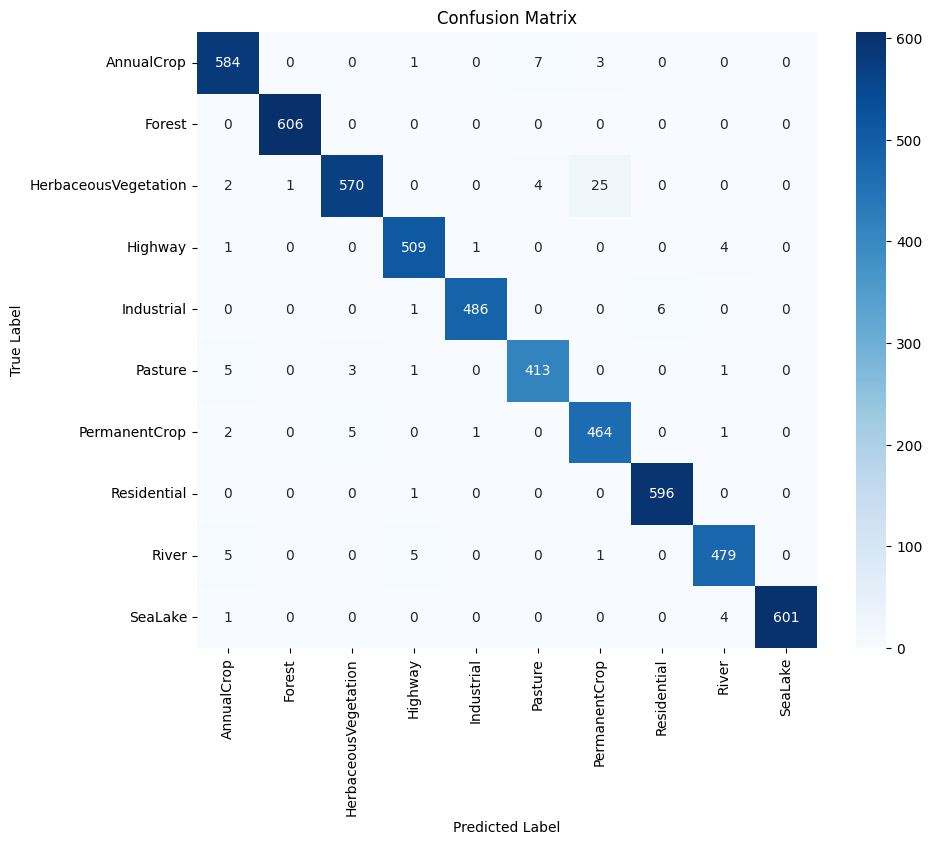

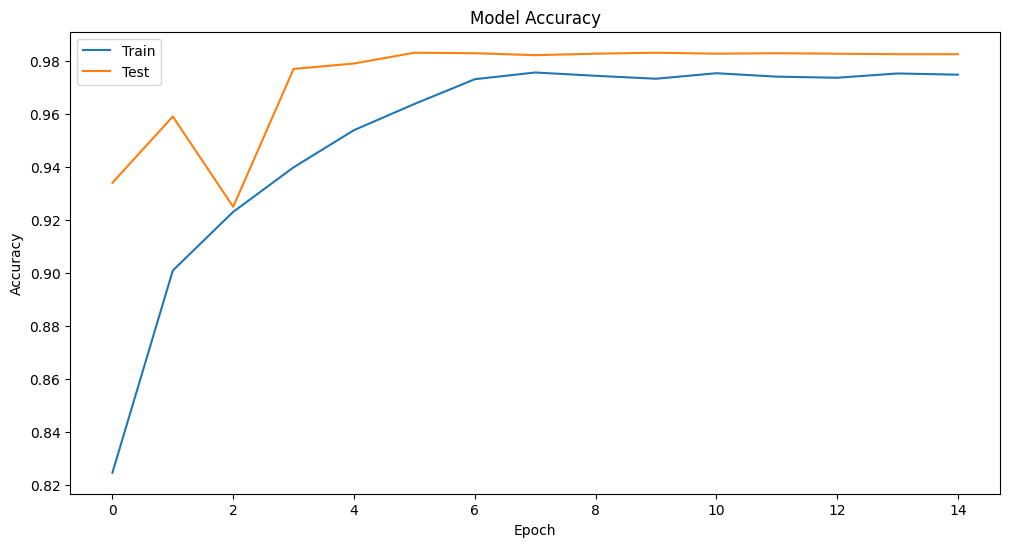

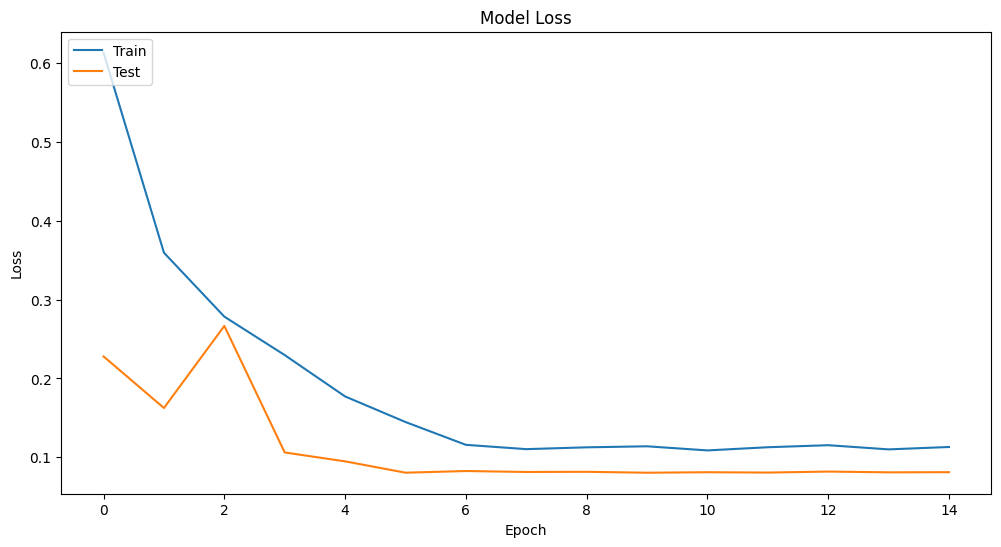

In [2]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, LSTM, TimeDistributed, Input, Reshape
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2

# Directory of the dataset
dataset_dir = '/kaggle/input/sat-image-rgb/EuroSAT_RGB'

# Categories of the dataset
categories = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

# Step 1: Convert the images to grayscale and load them into an array
def load_and_preprocess_images(dataset_dir, categories):
    images = []
    labels = []
    for category in categories:
        category_dir = os.path.join(dataset_dir, category)
        for img_name in os.listdir(category_dir):
            img_path = os.path.join(category_dir, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (128, 128))  # Increased resolution to 128x128
            
            # Apply CLAHE to each channel
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            for i in range(3):  
                img[:,:,i] = clahe.apply(img[:,:,i])
            
            images.append(img)
            labels.append(categories.index(category))
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Load and preprocess images
images, labels = load_and_preprocess_images(dataset_dir, categories)

# Reshape images to add the time dimension (needed for LSTM)
images = images.reshape((-1, 1, 128, 128, 3))  # Adding time dimension

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Custom data generator
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, batch_size, datagen):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.datagen = datagen
        self.indexes = np.arange(len(self.images))
    
    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.images[batch_indexes]
        batch_labels = self.labels[batch_indexes]
        
        # Perform augmentation only on the spatial dimensions
        augmented_images = np.zeros_like(batch_images)
        for i in range(batch_images.shape[0]):
            for t in range(batch_images.shape[1]):
                augmented_images[i, t] = self.datagen.random_transform(batch_images[i, t])
        
        return augmented_images, batch_labels

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Define a CNN + LSTM hybrid model with advanced fine-tuning and regularization
def build_model(hp):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    # Fine-tune the entire EfficientNetB0 model
    for layer in base_model.layers:
        layer.trainable = True

    input_layer = Input(shape=(1, 128, 128, 3))
    
    # Process each time step independently using TimeDistributed
    reshaped_input = Reshape((128, 128, 3))(input_layer)
    x = base_model(reshaped_input)
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, x.shape[1]))(x)  # Reshape to (batch_size, time_steps, features)
    
    lstm_out = LSTM(hp.Int('lstm_units', min_value=128, max_value=256, step=64), return_sequences=False)(x)
    
    dense_1 = Dense(hp.Int('units_1', min_value=128, max_value=256, step=64), activation='relu', kernel_regularizer=l2(1e-4))(lstm_out)
    dense_1 = BatchNormalization()(dense_1)
    dense_1 = Dropout(hp.Float('dropout_1', 0.3, 0.5, step=0.1))(dense_1)
    
    dense_2 = Dense(hp.Int('units_2', min_value=128, max_value=256, step=64), activation='relu', kernel_regularizer=l2(1e-4))(dense_1)
    dense_2 = BatchNormalization()(dense_2)
    dense_2 = Dropout(hp.Float('dropout_2', 0.3, 0.5, step=0.1))(dense_2)
    
    output_layer = Dense(len(categories), activation='softmax')(dense_2)
    
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4]),
        decay_steps=5000,
        alpha=0.0
    )

    model = Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Set up Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=2,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='sat_image_classification_optimized'
)

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Custom data generators
train_gen = CustomDataGenerator(X_train, y_train, batch_size=32, datagen=datagen)

# Run hyperparameter search
tuner.search(train_gen, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of LSTM units is {best_hps.get('lstm_units')},
the optimal number of units in the first layer is {best_hps.get('units_1')}, in the second layer is {best_hps.get('units_2')},
the optimal dropout rates are {best_hps.get('dropout_1')}, {best_hps.get('dropout_2')},
and the optimal learning rate is {best_hps.get('learning_rate')}.
""")

# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)

# Visualize the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

history = model.fit(train_gen, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

# Step 5: Evaluation

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=categories))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
